In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [61]:
def load_data_comp_train():
    train = pd.read_csv('../data/train.csv')
    client = pd.read_csv('../data/client.csv')
    electricity_prices = pd.read_csv('../data/electricity_prices.csv')
    forecast_weather = pd.read_csv('../data/forecast_weather.csv')
    gas_prices = pd.read_csv('../data/gas_prices.csv')
    historical_weather = pd.read_csv('../data/historical_weather.csv')

    return (train, client, electricity_prices, forecast_weather,
            gas_prices, historical_weather)


def load_data_comp_test():
    test = pd.read_csv('../data/example_test_files/test.csv')
    client_test = pd.read_csv('../data/example_test_files/client.csv')
    electricity_prices_test = pd.read_csv('../data/example_test_files/electricity_prices.csv')
    forecast_weather_test = pd.read_csv('../data/example_test_files/forecast_weather.csv')
    gas_prices_test = pd.read_csv('../data/example_test_files/gas_prices.csv')
    historical_weather_test = pd.read_csv('../data/historical_weather.csv')

    return (test, client_test, electricity_prices_test, forecast_weather_test,
            gas_prices_test, historical_weather_test)


def graficar_ts(data, date_time, target_column, freq = 'M', group_by = None, title = None):
        
    if data[date_time].dtype == 'O':
        data[date_time] = pd.to_datetime(data[date_time])
        
    if group_by:
        train_time = data[[date_time, target_column, group_by]].copy()
        train_time.index = train_time[date_time]
        train_time.drop(date_time, axis=1, inplace=True)
        # Agrupar por mes y calcular el resumen (por ejemplo, la suma)
        try:
            resumen_mensual = train_time.groupby(group_by).resample(freq, on=date_time).sum()
        except KeyError:
            resumen_mensual = train_time.groupby(group_by).resample(freq).sum()
        plt.figure(figsize=(18, 6))
        # Graficar
        for group in resumen_mensual.index.get_level_values(group_by).unique():
            plt.plot(resumen_mensual.loc[group].index, resumen_mensual.loc[group][target_column], label=group)
        plt.title(title if title else 'Resumen Mensual')
        plt.xlabel('Mes')
        plt.ylabel('Valor')
        plt.legend()
        plt.show()
    else:
        train_time = data[[date_time, target_column]].copy()
        train_time.index = train_time[date_time]
        train_time.drop(date_time, axis=1, inplace=True)
        # Agrupar por mes y calcular el resumen (por ejemplo, la suma)
        try:
            resumen_mensual = train_time.resample(freq, on=date_time).sum()
        except KeyError:
            resumen_mensual = train_time.resample(freq).sum()
        plt.figure(figsize=(18, 6))
        # Graficar
        resumen_mensual.plot()
        plt.title(title if title else 'Resumen Mensual')
        plt.xlabel('Mes')
        plt.ylabel('Valor')
        plt.show()
    return

In [4]:
train, client, electricity_prices, forecast_weather, gas_prices, historical_weather = load_data_comp_train()
test, client_test, electricity_prices_test, forecast_weather_test, gas_prices_test, historical_weather_test = load_data_comp_test()

# Análisis Exploratorio de Datos

En esta sección realizaremos un análisis descriptivo de los datos de enefit, para entender su relacion y cómo construir nuevas variables para los modelos

## Train

* county - An ID code for the county.
* is_business - Boolean for whether or not the prosumer is a business.
* product_type - ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.
* target - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.
* is_consumption - Boolean for whether or not this row's target is consumption or production.
* datetime - The Estonian time in EET (UTC+2) / EEST (UTC+3). It describes the start of the 1-hour period on which target is given.
* data_block_id - All rows sharing the same data_block_id will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather data_block_id for predictins made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.
* row_id - A unique identifier for the row.
* prediction_unit_id - A unique identifier for the county, is_business, and product_type combination. New prediction units can appear or disappear in the test set.

In [5]:
cat_vars = [
    'county',
    'is_business',
    'product_type',
    'is_consumption',
    'data_block_id',
    'row_id',
    'prediction_unit_id'
]

for col in cat_vars:
    train[col] = train[col].astype('category')

In [6]:
train.describe(include='all')

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
count,2018352.0,2018352.0,2018352.0,2.017824e+06,2018352.0,2018352,2018352.0,2018352.0,2018352.0
unique,16.0,2.0,4.0,NaN,2.0,15312,638.0,2018352.0,69.0
top,0.0,1.0,3.0,NaN,0.0,2022-11-27 12:00:00,452.0,0.0,0.0
freq,212928.0,1083504.0,918720.0,NaN,1009176.0,138,3312.0,1.0,30624.0
mean,NaN,NaN,NaN,2.748556e+02,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,9.095024e+02,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,3.780000e-01,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,3.113300e+01,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,1.802062e+02,NaN,NaN,NaN,NaN,NaN


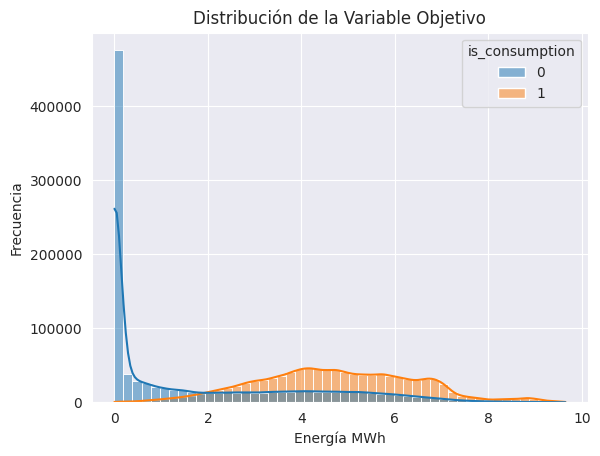

In [12]:
sns.histplot(x= np.log(train['target']+1), hue= train['is_consumption'], bins=50, kde=True)
plt.title('Distribución de la Variable Objetivo')
plt.xlabel('Energía MWh')
plt.ylabel('Frecuencia')
plt.show()

La variable objetivo 'target' tiene una distribución asimétrica positiva, con la mayoría de los valores alrededor de 0-100 y algunos valores extremadamente altos. Esto sugiere que la variable objetivo puede tener valores atípicos o extremos que podrían afectar el rendimiento de los modelos. Separamos los datos en dos grupos, uno con valores de 'target' menores o iguales al límite superior del rango intercuartílico (Q3 + 1.5 * IQR) y otro con valores mayores a este límite. Luego, podemos analizar las diferencias entre estos dos grupos para comprender mejor la distribución de 'target'.

In [13]:
train['is_outlier'] = train['target'] > train['target'].quantile(0.75) + 1.5 * (train['target'].quantile(0.75) - train['target'].quantile(0.25))

In [14]:
train['is_outlier'].value_counts()

is_outlier
False    1744135
True      274217
Name: count, dtype: int64

In [15]:
train['is_outlier'] = train['is_outlier'].astype(int)

In [50]:
def some_plots(data, target_column, log = False, hue = None):
    if log:
        data[target_column] = np.log(data[target_column] + 1)
        
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

    sns.boxplot(data=data, x='county', y=target_column, hue=hue, ax=axes[0, 0])
    axes[0, 0].set_title('Target vs County')

    sns.boxplot(data=data, x='is_business', y=target_column,  hue=hue, ax=axes[0, 1])
    axes[0, 1].set_title('Target vs Is Business')

    sns.boxplot(data=data, x='product_type', y=target_column, hue=hue,  ax=axes[0, 2])
    axes[0, 2].set_title('Target vs Product Type')

    sns.boxplot(data=data, x='is_consumption', y=target_column, ax=axes[1, 0])
    axes[1, 0].set_title('Target vs Is Consumption')
    
    if hue:
        data_temp0 = data[['data_block_id',target_column, hue]].groupby(['data_block_id', hue]).sum().reset_index()
        sns.lineplot(data=data_temp0, x='data_block_id', y=target_column, hue=hue, ax=axes[1, 1])
        axes[1, 1].set_title('Target vs Data Block ID')
    else:
        data_temp0 = data[['data_block_id',target_column]].groupby(['data_block_id']).sum().reset_index()
        sns.lineplot(data=data_temp0, x='data_block_id', y=target_column, ax=axes[1, 1])
        axes[1, 1].set_title('Target vs Data Block ID')
    
    # Convert 'datetime' column to datetime format
    if data['datetime'].dtype == 'O':
        data['datetime'] = pd.to_datetime(data['datetime'])
    
    # Set 'datetime' as the index before resampling
    data_tmp = data.copy()[[target_column, 'datetime', hue]]
    data_tmp['year'] = data_tmp['datetime'].dt.year.astype(str)
    data_tmp['month'] = data_tmp['datetime'].dt.month.astype(str)
    data_tmp2 = data_tmp.groupby(['year', 'month', hue])[target_column].sum().reset_index()
    data_tmp2['datetime'] = data_tmp2.year + '-' + data_tmp2.month
    sns.lineplot(data=data_tmp2, x='datetime', y=target_column, hue=hue, ax=axes[1, 2])
    axes[1, 2].set_title('Target vs Datetime')

    plt.tight_layout()

    plt.show()

## Gráficos de no outliers

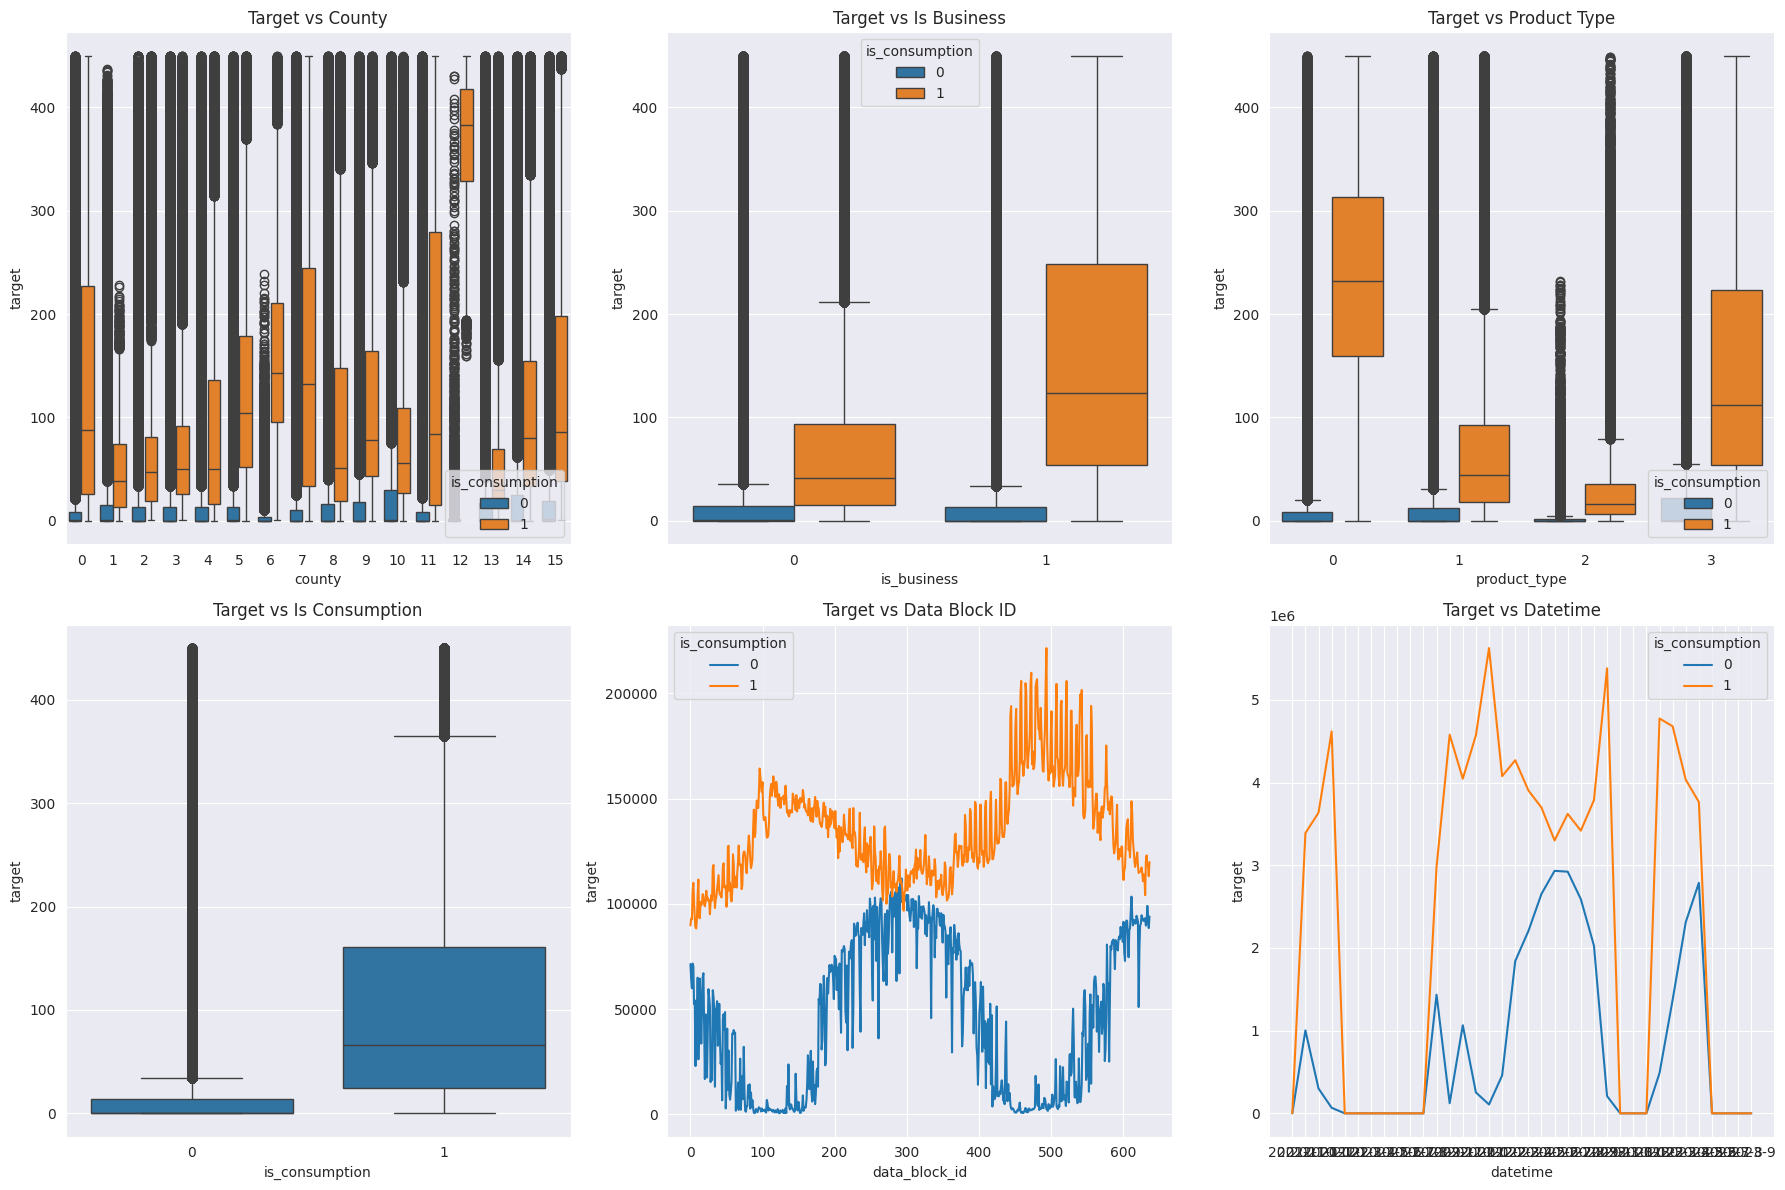

In [51]:
some_plots(train[train['is_outlier'] == 0], 'target', log=False, hue= 'is_consumption')

Los gráficos muestran diferencias en la distribución de 'target' en función de las variables categóricas 'county', 'is_business', 'product_type' e 'is_consumption'. Por ejemplo, 'target' parece variar entre diferentes condados, tipos de producto y si el cliente es un negocio o no. Estas diferencias pueden ser útiles para la construcción de características y la selección de variables en los modelos de aprendizaje automático.

## Gráficos de outliers

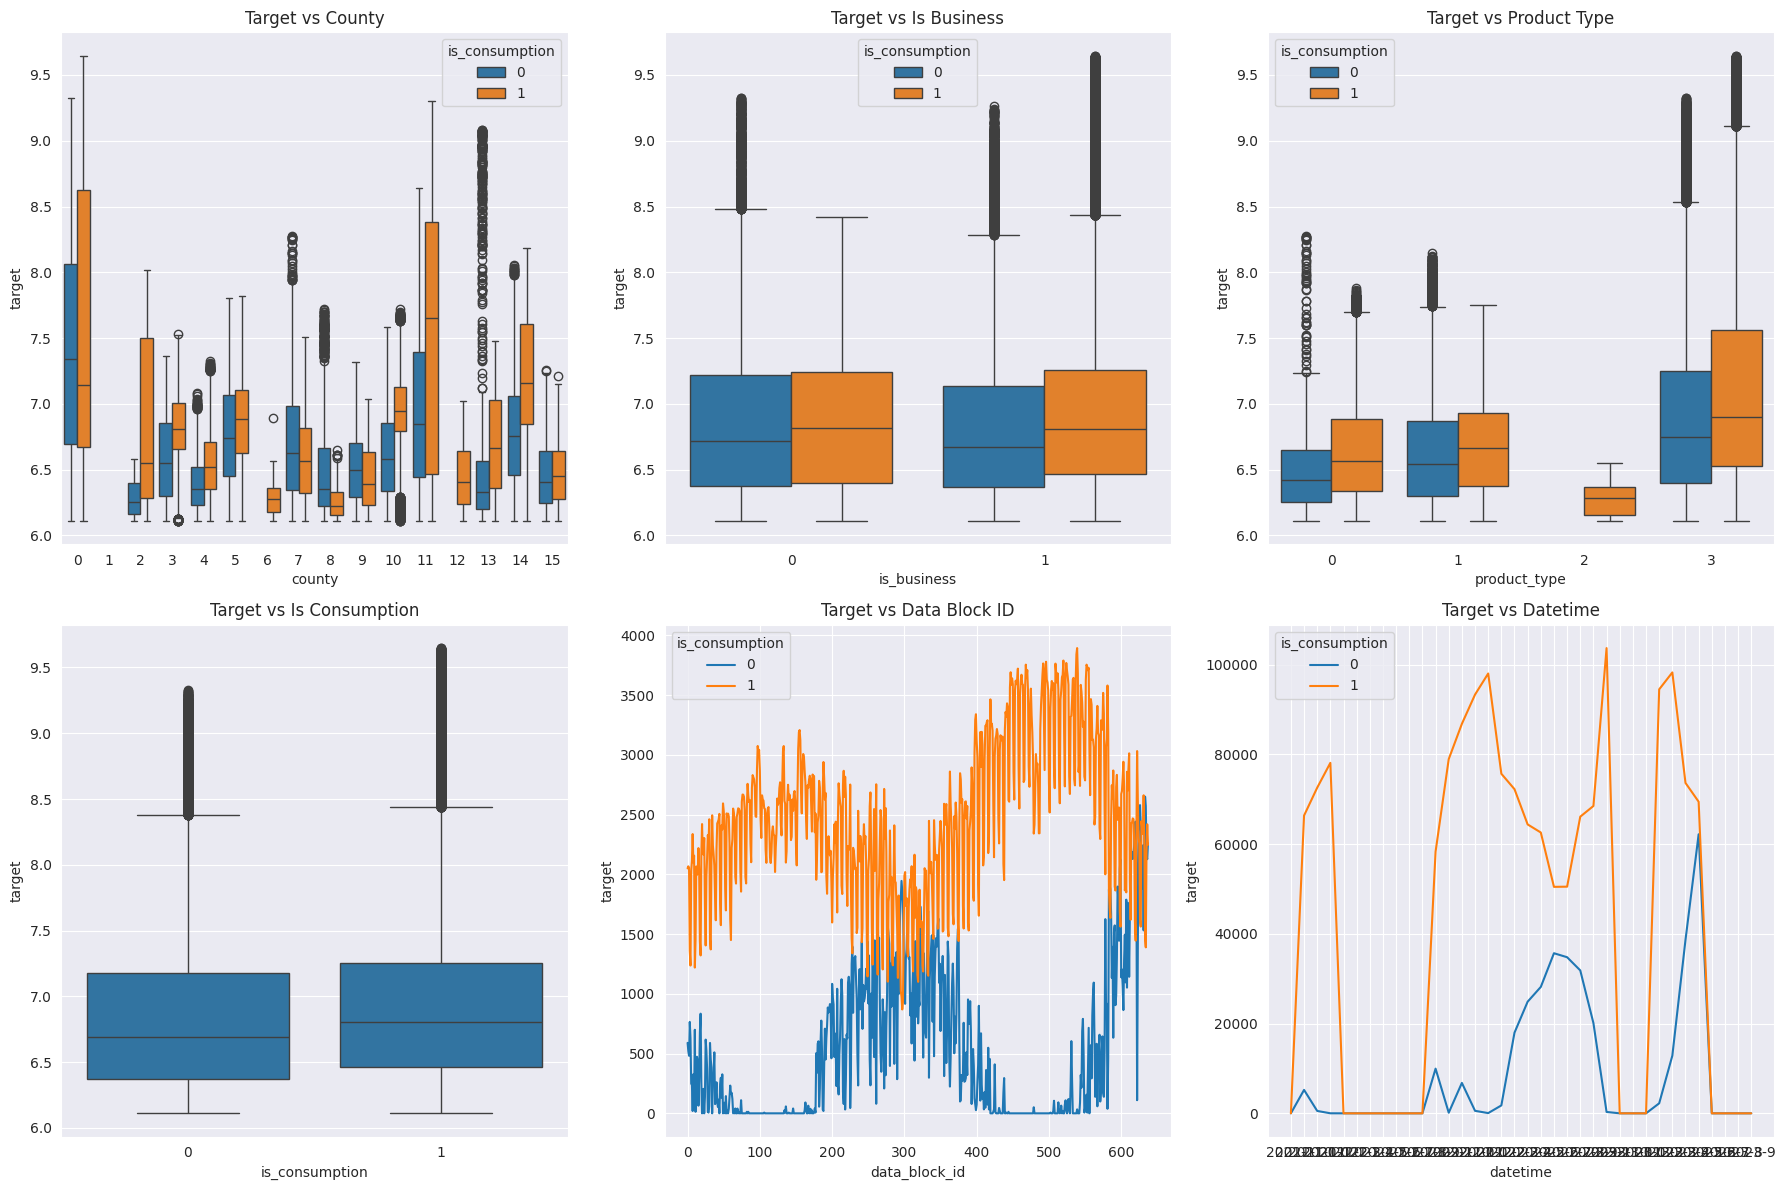

In [52]:
some_plots(train[train['is_outlier'] == 1], 'target', log=True, hue= 'is_consumption')

Los gráficos de los valores atípicos muestran diferencias similares en la distribución de 'target' en función de las variables categóricas. Esto sugiere que las diferencias observadas en los datos no atípicos también se aplican a los valores atípicos. La presencia de valores atípicos en la variable objetivo puede ser importante para el modelado y la predicción, ya que estos valores extremos pueden influir en la precisión de los modelos.

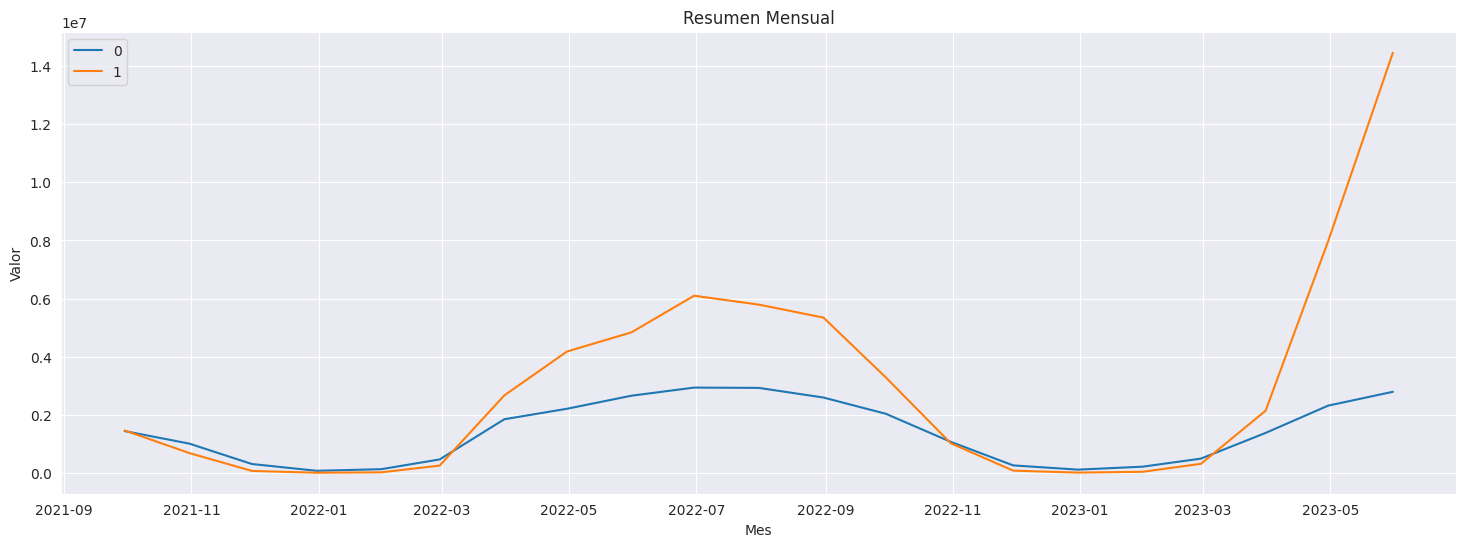

In [55]:
graficar_ts(train.loc[train.is_consumption==0], 'datetime', 'target', group_by='is_outlier')

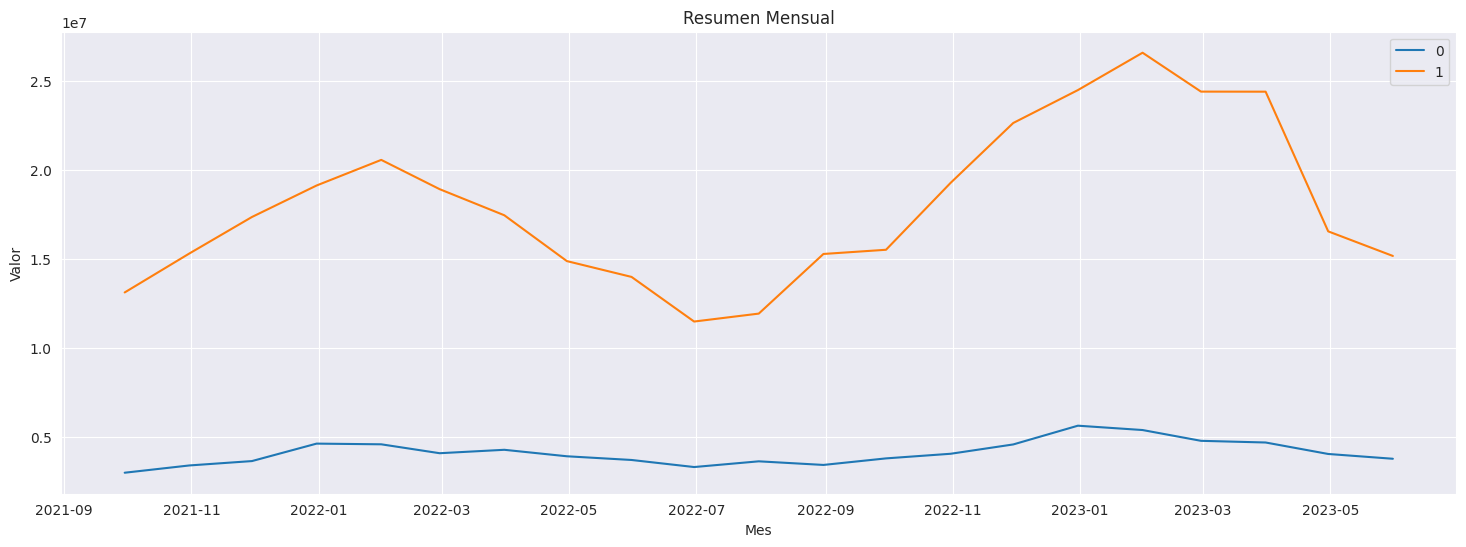

In [56]:
graficar_ts(train.loc[train.is_consumption==1], 'datetime', 'target', group_by='is_outlier')

El gráfico de serie temporal de 'target' con la variable 'is_outlier' como variable categórica muestra diferencias en la tendencia temporal entre los valores atípicos y no atípicos. Los valores atípicos parecen tener una tendencia más pronunciada en comparación con los valores no atípicos. Esto sugiere que la presencia de valores atípicos puede influir en la tendencia temporal de la variable objetivo.

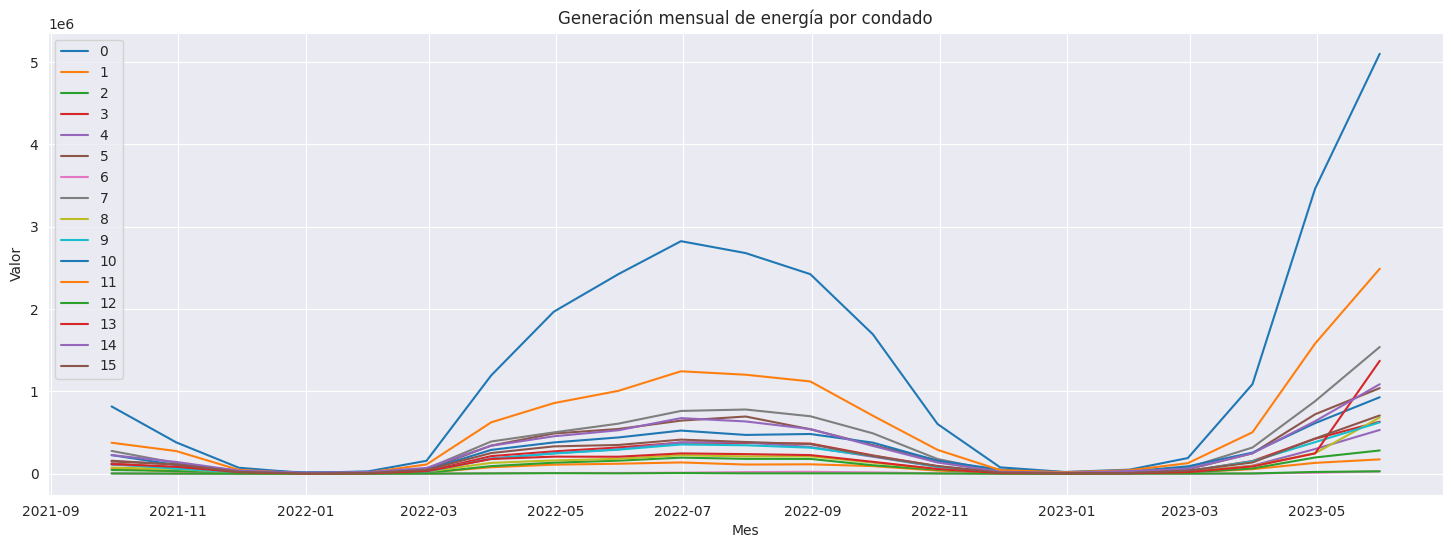

In [63]:
graficar_ts(train.loc[train.is_consumption==0], 'datetime', 'target', group_by='county', title='Generación mensual de energía por condado')

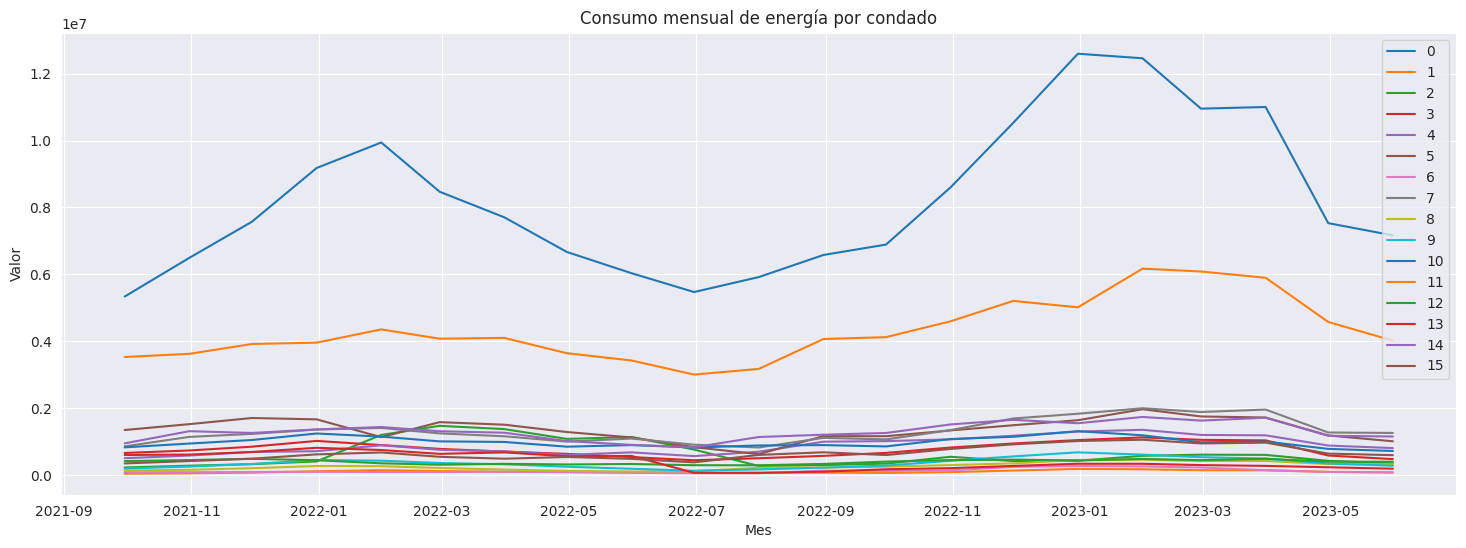

In [64]:
graficar_ts(train.loc[train.is_consumption==1], 'datetime', 'target', group_by='county', title='Consumo mensual de energía por condado')

El gráfico de serie temporal de 'target' con la variable 'county' como variable categórica muestra diferencias en la tendencia temporal entre los diferentes condados. Algunos condados tienen una tendencia más pronunciada en comparación con otros, lo que sugiere que la ubicación geográfica puede influir en la variable objetivo.

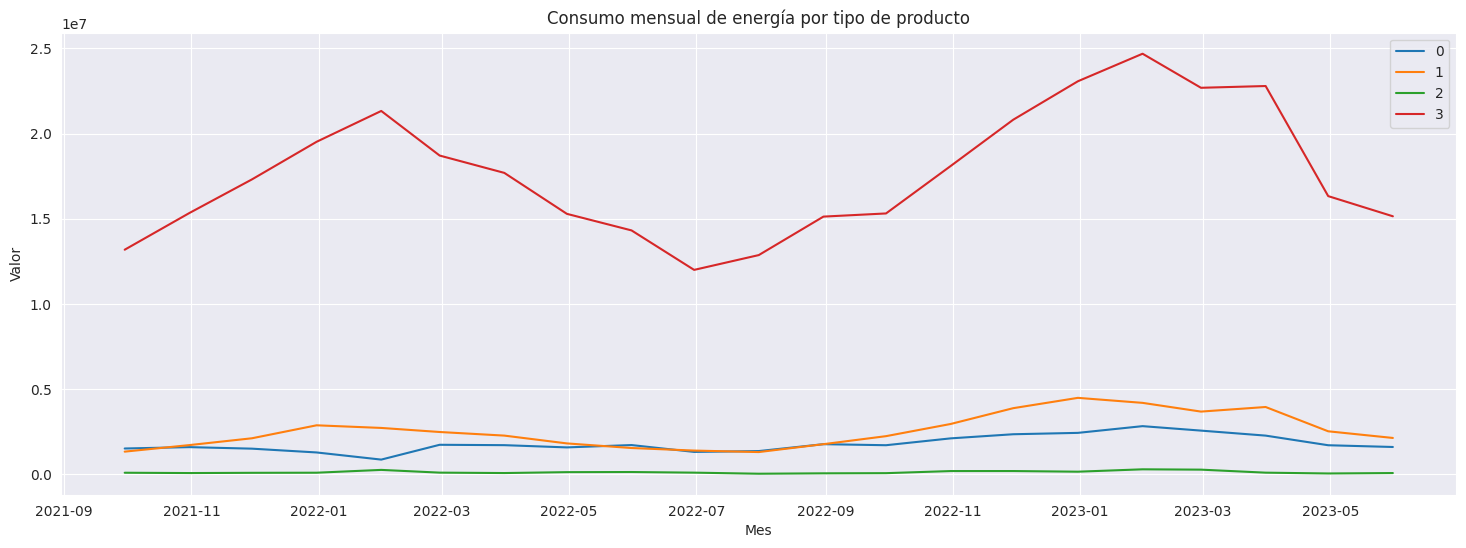

In [65]:
graficar_ts(train.loc[train.is_consumption==1], 'datetime', 'target', group_by='product_type', title='Consumo mensual de energía por tipo de producto')

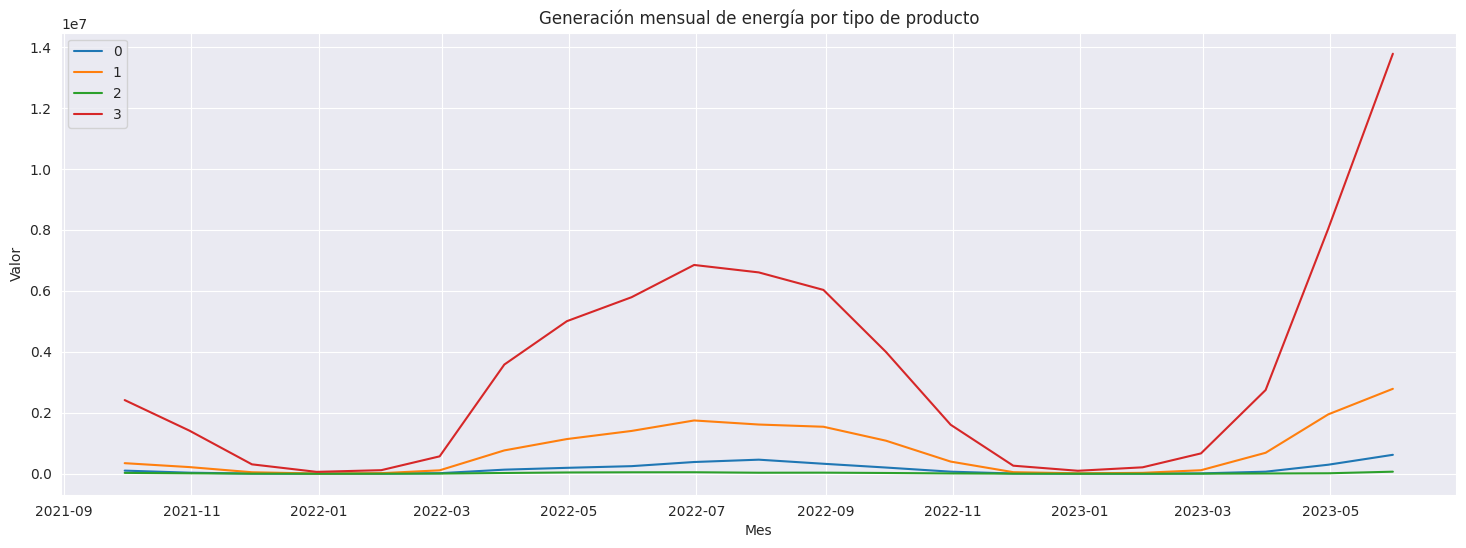

In [66]:
graficar_ts(train.loc[train.is_consumption==0], 'datetime', 'target', group_by='product_type', title='Generación mensual de energía por tipo de producto')

El gráfico de serie temporal de 'target' con la variable 'product_type' como variable categórica muestra diferencias en la tendencia temporal entre los diferentes tipos de producto. Algunos tipos de producto tienen una tendencia más pronunciada en comparación con otros, lo que sugiere que el tipo de producto puede influir en la variable objetivo.

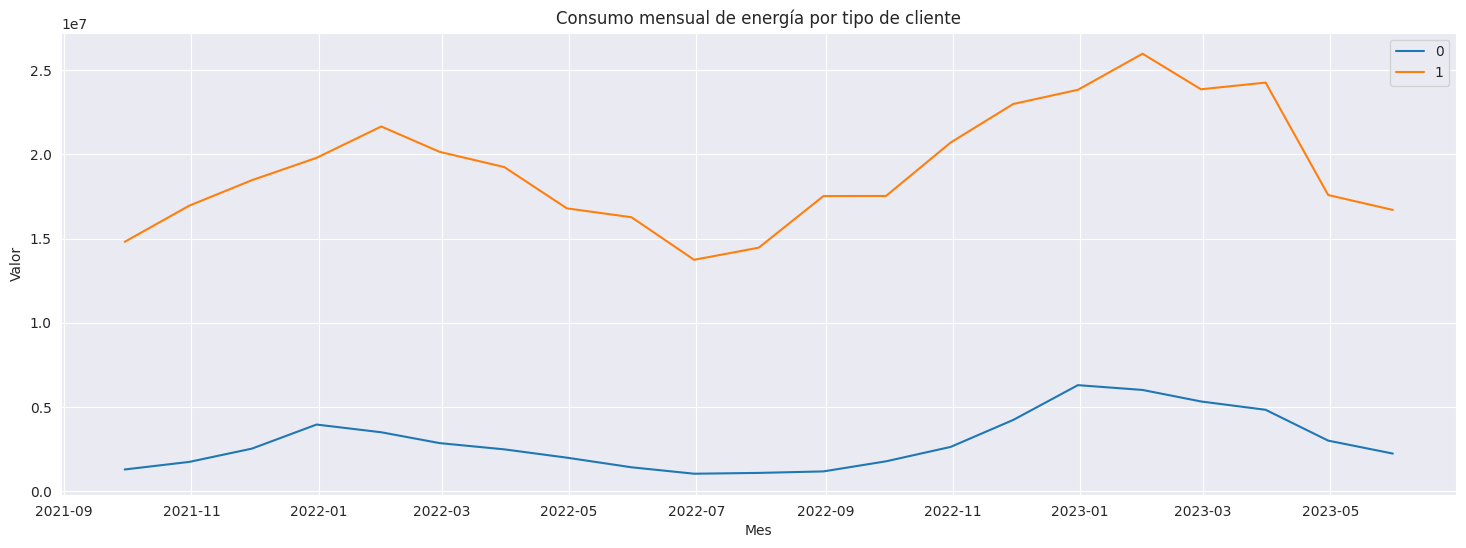

In [67]:
graficar_ts(train.loc[train.is_consumption==1], 'datetime', 'target', group_by='is_business', title='Consumo mensual de energía por tipo de cliente')

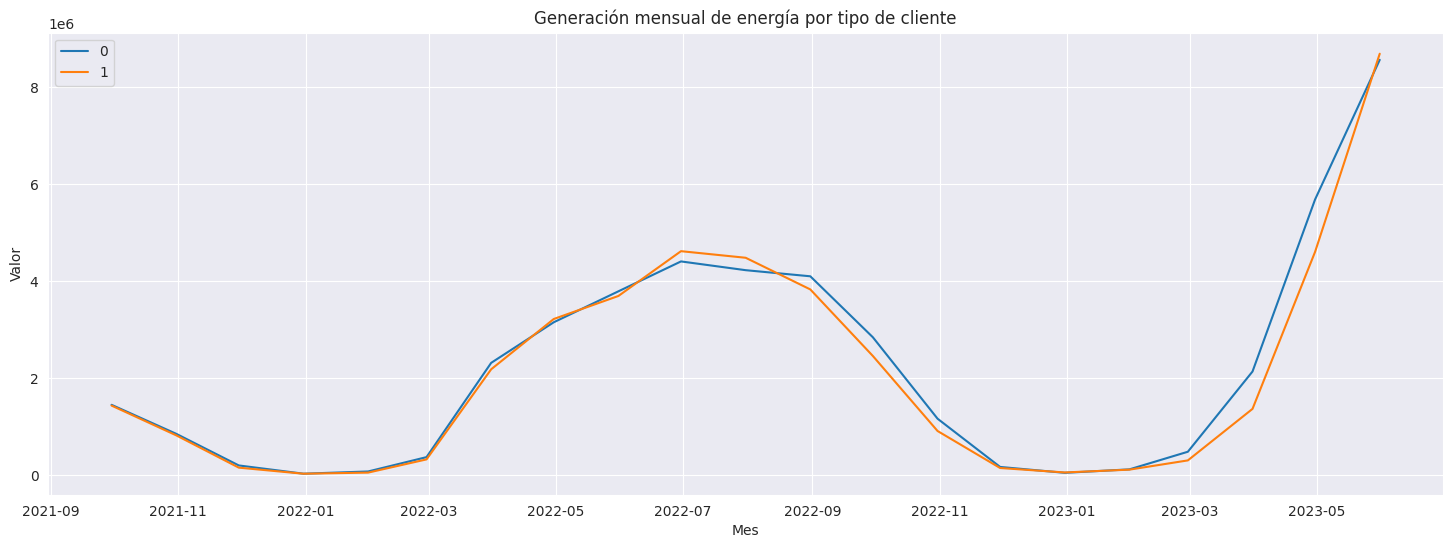

In [68]:
graficar_ts(train.loc[train.is_consumption==0], 'datetime', 'target', group_by='is_business', title='Generación mensual de energía por tipo de cliente')

El gráfico de serie temporal de 'target' con la variable 'is_business' como variable categórica muestra diferencias en la tendencia temporal entre los clientes comerciales y no comerciales. Los clientes comerciales tienen una tendencia más pronunciada en comparación con los no comerciales, lo que sugiere que el tipo de cliente puede influir en la variable objetivo.

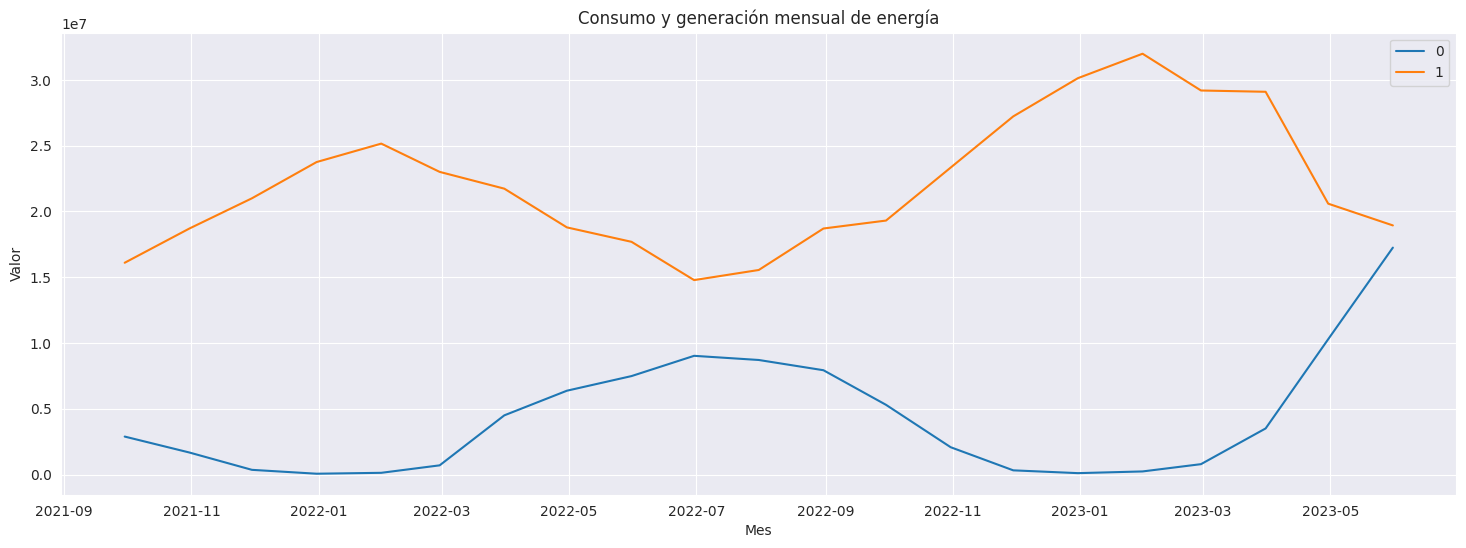

In [69]:
graficar_ts(train, 'datetime', 'target', group_by='is_consumption', title='Consumo y generación mensual de energía')

In [70]:
numericas = [column for column in train.columns if train[column].dtype in ['int64', 'float64']]

In [72]:
# sns.heatmap(train[numericas].corr(), annot=True, cmap='coolwarm', fmt=".2f")
# plt.show()

## Cliente

El archivo client.csv contiene datos relacionados con instalaciones de algún tipo, posiblemente energéticas, dada la presencia de una columna de 'installed_capacity'. Las columnas presentes en el DataFrame son:

**product_type:** Un identificador numérico para el tipo de producto.
**county:** Un identificador para el condado.
**eic_count:** Número de alguna entidad (quizás instalaciones o equipos).
**installed_capacity:** Capacidad instalada, probablemente medida en alguna unidad de energía o potencia.
**is_business:** Un indicador binario que probablemente distingue entre clientes comerciales (1) y no comerciales (0).
**date:** La fecha de registro o medición.
**data_block_id:** Un identificador para el bloque de datos.

Para realizar un análisis exploratorio de esta data, podemos:

* Revisar estadísticas descriptivas básicas para cada columna numérica.
* Verificar la presencia de valores nulos en el conjunto de datos.
* Analizar la distribución de los datos en las columnas clave.
* Explorar tendencias temporales si la columna 'date' es relevante.
* Investigar las relaciones entre las distintas columnas, como capacidad instalada vs tipo de producto, o capacidad instalada en función de si el cliente es un negocio o no.

Vamos a comenzar con los pasos 1 y 2 para obtener una visión general del conjunto de datos.

* product_type
* county - An ID code for the county. See county_id_to_name_map.json for the mapping of ID codes to county names.
* eic_count - The aggregated number of consumption points (EICs - European Identifier Code).
* installed_capacity - Installed photovoltaic solar panel capacity in kilowatts.
* is_business - Boolean for whether or not the prosumer is a business.
* date
* data_block_id

In [20]:
client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [21]:
client.date = pd.to_datetime(client.date)
client = client.rename(columns={'date': 'datetime_client'})

Las estadísticas descriptivas y la verificación de valores nulos nos proporcionan información valiosa sobre el conjunto de datos:

### Estadísticas Descriptivas

* **product_type:** Varía de 0 a 3, lo que sugiere que hay cuatro tipos de productos.
* **county:** Los valores varían de 0 a 15, indicando 16 condados diferentes.
* **eic_count:** El número de entidades varía ampliamente, con un mínimo de 5 y un máximo de 1517.
* **installed_capacity:** La capacidad instalada también muestra una gran variación, desde 5.5 hasta 19314.31 (unidad no especificada).
* **is_business:** Alrededor del 54% de los registros corresponden a negocios.
* **data_block_id:** Varía de 2 a 637, lo que podría indicar diferentes lotes o grupos de datos.

### Valores Nulos
No hay valores nulos en ninguna de las columnas, lo que indica que el conjunto de datos está completo en términos de registros.

Próximos Pasos para el Análisis
Para profundizar en el análisis, podríamos:

Explorar la distribución de 'installed_capacity' para entender mejor cómo se distribuye esta variable.
Examinar cómo varía 'installed_capacity' en función del tipo de producto y si el cliente es un negocio o no.
Analizar las tendencias temporales si las fechas son relevantes, para ver cómo varía la capacidad instalada a lo largo del tiempo.
Procederé con el análisis de la distribución de 'installed_capacity' y cómo varía esta en función de 'product_type' y 'is_business'. También echaré un vistazo a las tendencias temporales. ​

In [22]:
client.describe(include='all')

,product_type,county,eic_count,installed_capacity,is_business,datetime_client,data_block_id
count,41919.000000,41919.000000,41919.000000,41919.000000,41919.000000,41919,41919.000000
mean,1.898996,7.297097,73.345118,1450.771451,0.536773,2022-07-18 21:34:22.921348096,322.898876
min,0.000000,0.000000,5.000000,5.500000,0.000000,2021-09-01 00:00:00,2.000000
25%,1.000000,3.000000,13.000000,321.900000,0.000000,2022-02-13 00:00:00,167.000000
50%,2.000000,7.000000,32.000000,645.200000,1.000000,2022-07-20 00:00:00,324.000000
75%,3.000000,11.000000,70.000000,1567.150000,1.000000,2022-12-23 00:00:00,480.000000
max,3.000000,15.000000,1517.000000,19314.310000,1.000000,2023-05-29 00:00:00,637.000000
std,1.081713,4.780750,144.064389,2422.233120,0.498652,NaN,182.075724


In [23]:
# Verificar la presencia de valores nulos en el conjunto de datos
null_values = client.isnull().sum()

null_values

product_type          0
county                0
eic_count             0
installed_capacity    0
is_business           0
datetime_client       0
data_block_id         0
dtype: int64

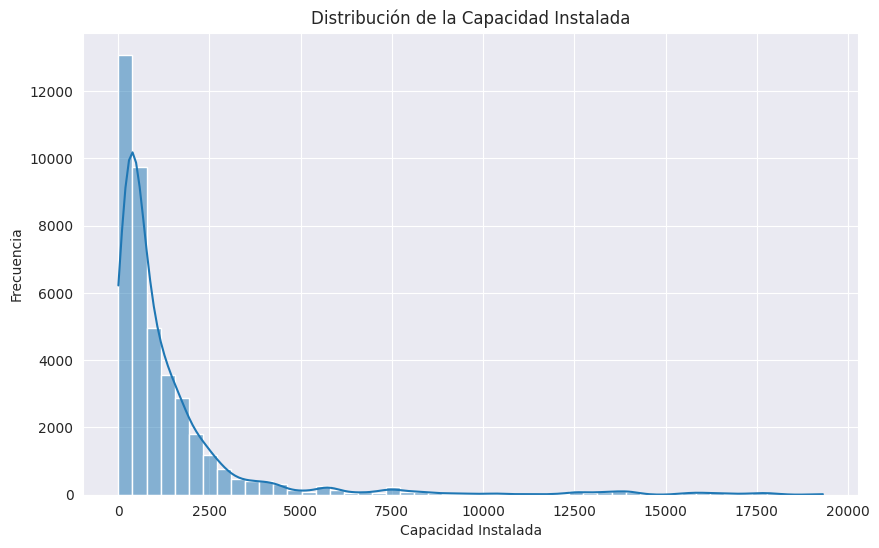

In [24]:
# Distribución de 'installed_capacity'  
plt.figure(figsize=(10, 6))
sns.histplot(client['installed_capacity'], bins=50, kde=True)
plt.title('Distribución de la Capacidad Instalada')
plt.xlabel('Capacidad Instalada')
plt.ylabel('Frecuencia')
plt.show()

La gráfica de la distribución de 'installed_capacity' muestra que la mayoría de los valores se encuentran en el rango de 0 a 5000, con algunos valores extremadamente altos. Esto sugiere que la variable 'installed_capacity' tiene valores atípicos o extremos que podrían afectar el rendimiento de los modelos. Esto sugiere que algunos prosumidores tienen una capacidad instalada significativamente mayor que otros, lo que podría influir en la predicción de la producción o consumo de energía.

Se podría dividir los datos en dos grupos, uno con valores de 'installed_capacity' menores o iguales al límite superior del rango intercuartílico (Q3 + 1.5 * IQR) y otro con valores mayores a este límite. Luego, se podrían analizar las diferencias entre estos dos grupos para comprender mejor la distribución de 'installed_capacity'.

In [25]:
client['is_outlier'] = client['installed_capacity'] > client['installed_capacity'].quantile(0.75) + 1.5 * (client['installed_capacity'].quantile(0.75) - client['installed_capacity'].quantile(0.25))

In [26]:
client['is_outlier'] = client['is_outlier'].astype(int)

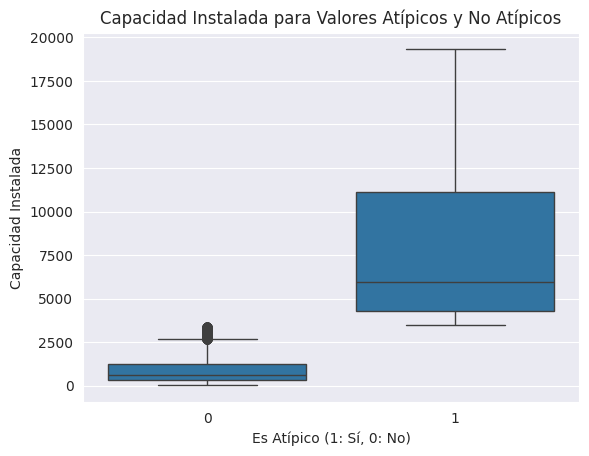

In [27]:
sns.boxplot(x='is_outlier', y='installed_capacity', data=client)
plt.title('Capacidad Instalada para Valores Atípicos y No Atípicos')
plt.xlabel('Es Atípico (1: Sí, 0: No)')
plt.ylabel('Capacidad Instalada')
plt.show()

A continuación, se presentan los gráficos de 'installed_capacity' en función de 'is_business' y 'product_type' para analizar cómo varía la capacidad instalada en función de estas variables categóricas. Además se diferencia entre los valores atípicos y no atípicos para comprender mejor las diferencias en la distribución de 'installed_capacity'.

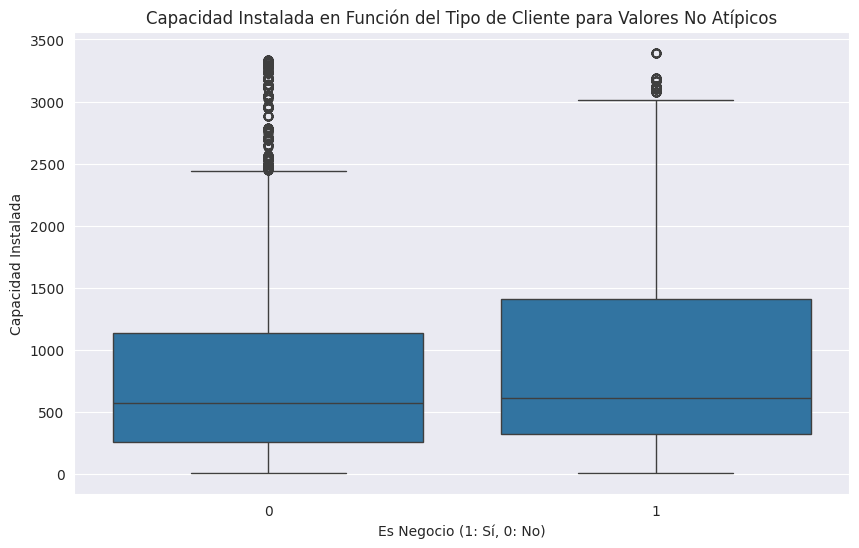

In [28]:
# Capacidad instalada en función de si es un negocio o no
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_business', y='installed_capacity', data=client[client['is_outlier'] == 0])
plt.title('Capacidad Instalada en Función del Tipo de Cliente para Valores No Atípicos')
plt.xlabel('Es Negocio (1: Sí, 0: No)')
plt.ylabel('Capacidad Instalada')
plt.show()

El gráfico de caja de 'installed_capacity' en función de 'is_business' muestra que los clientes comerciales tienden a tener una capacidad instalada más alta en comparación con los no comerciales. Esto sugiere que la variable 'is_business' puede ser importante para predecir la capacidad instalada de los prosumidores.

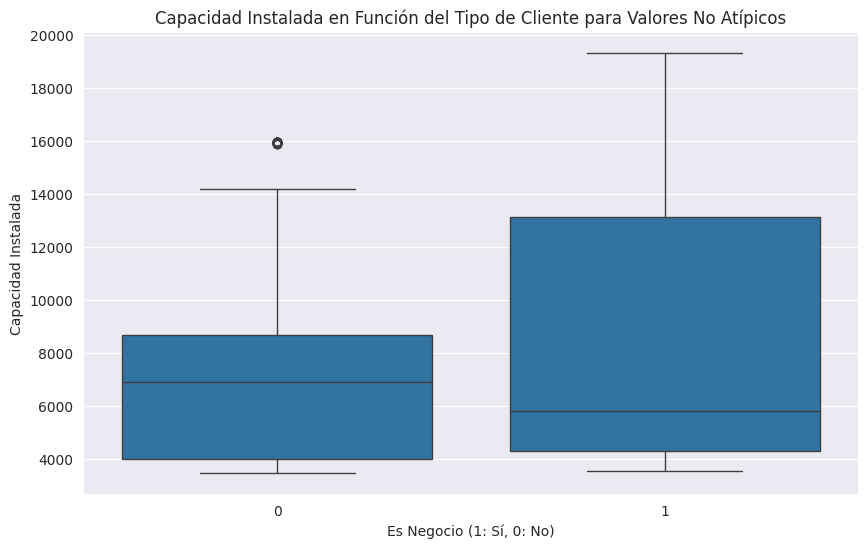

In [29]:
# Capacidad instalada en función de si es un negocio o no
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_business', y='installed_capacity', data=client[client['is_outlier'] == 1])
plt.title('Capacidad Instalada en Función del Tipo de Cliente para Valores No Atípicos')
plt.xlabel('Es Negocio (1: Sí, 0: No)')
plt.ylabel('Capacidad Instalada')
plt.show()

El gráfico de caja de 'installed_capacity' en función de 'is_business' para valores atípicos muestra una tendencia similar a los valores no atípicos. Los clientes comerciales tienden a tener una capacidad instalada más alta en comparación con los no comerciales, lo que sugiere que la variable 'is_business' es importante para predecir la capacidad instalada de los prosumidores.

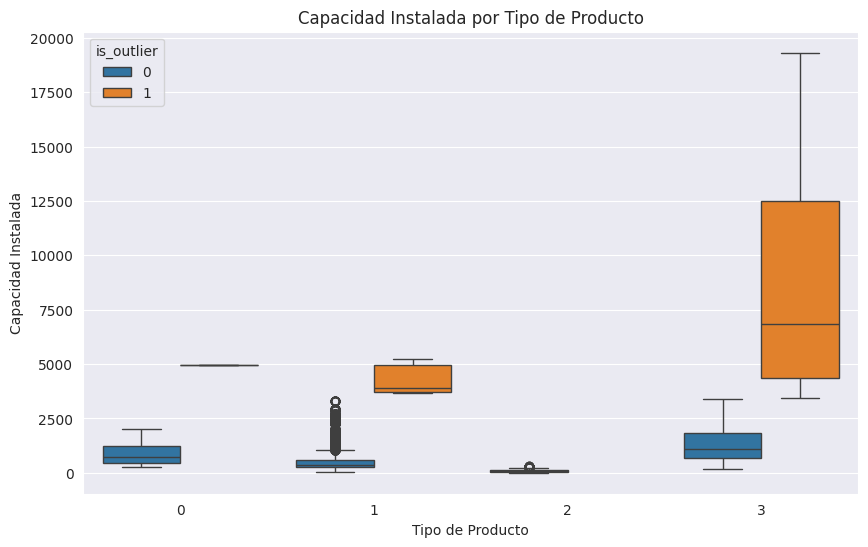

In [30]:
# Capacidad instalada en función del tipo de producto
plt.figure(figsize=(10, 6))
sns.boxplot(x='product_type', y='installed_capacity', hue= 'is_outlier', data=client)
plt.title('Capacidad Instalada por Tipo de Producto')
plt.xlabel('Tipo de Producto')
plt.ylabel('Capacidad Instalada')
plt.show()

El gráfico de caja de 'installed_capacity' en función de 'product_type' muestra diferencias en la capacidad instalada entre los diferentes tipos de producto. Por ejemplo, el tipo de producto 2 tiene una capacidad instalada más alta en comparación con los otros tipos de producto. Esto sugiere que el tipo de producto puede influir en la capacidad instalada de los prosumidores.

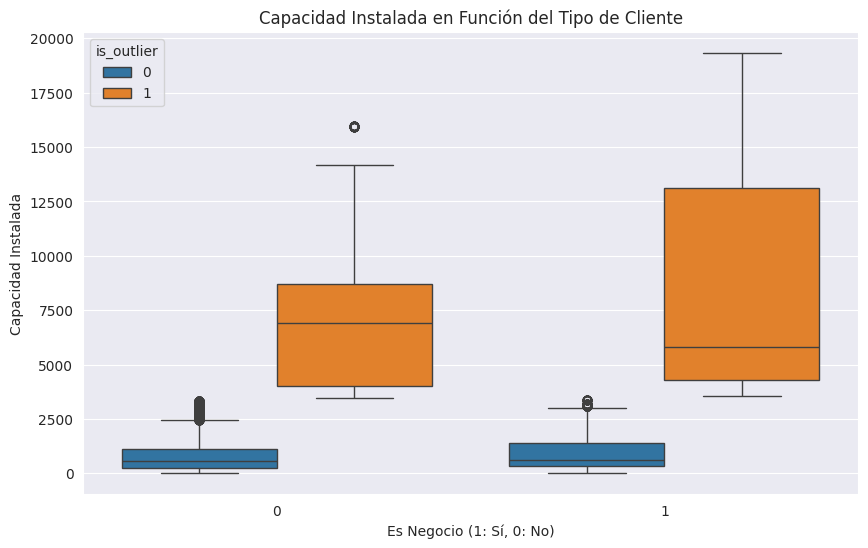

In [31]:
# Capacidad instalada en función de si es un negocio o no
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_business', y='installed_capacity',  hue= 'is_outlier', data=client)
plt.title('Capacidad Instalada en Función del Tipo de Cliente')
plt.xlabel('Es Negocio (1: Sí, 0: No)')
plt.ylabel('Capacidad Instalada')
plt.show()

El gráfico de caja de 'installed_capacity' en función de 'is_business' muestra diferencias en la capacidad instalada entre los clientes comerciales y no comerciales. Los clientes comerciales tienden a tener una capacidad instalada más alta en comparación con los no comerciales, lo que sugiere que la variable 'is_business' es importante para predecir la capacidad instalada de los prosumidores. Se observa además que hay clientes no comerciales con capacidad instalada muy alta.

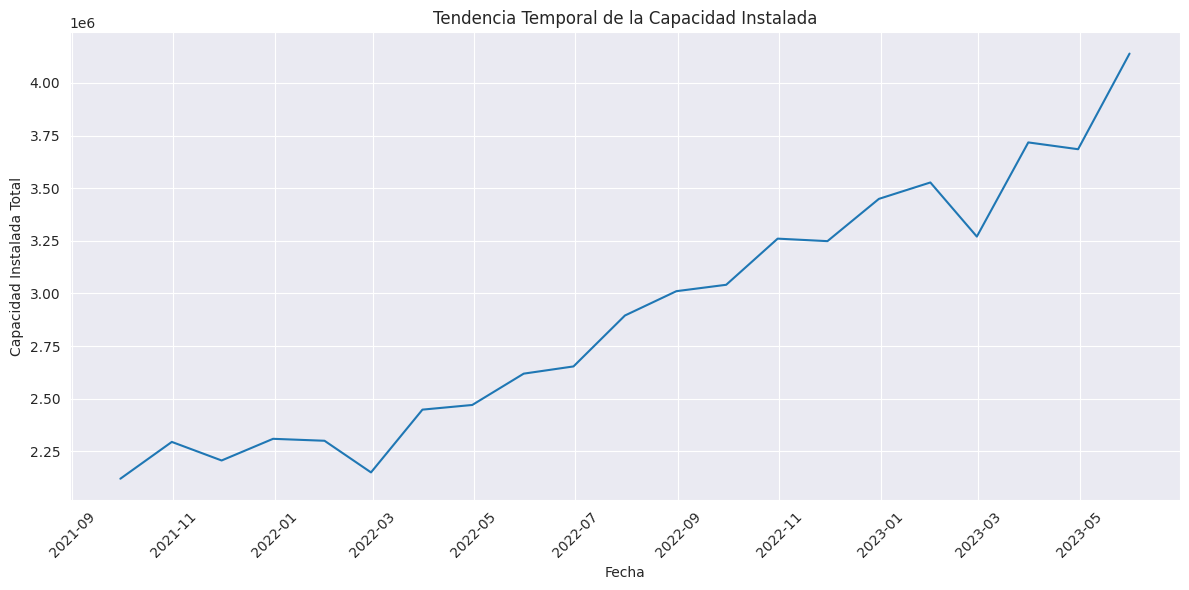

In [32]:
# Tendencias temporales
plt.figure(figsize=(12, 6))
df_resampled = client[['datetime_client', 'installed_capacity']].resample('M', on='datetime_client').sum()
plt.plot(df_resampled['installed_capacity'])
plt.title('Tendencia Temporal de la Capacidad Instalada')
plt.xlabel('Fecha')
plt.ylabel('Capacidad Instalada Total')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El gráfico de la tendencia temporal de la capacidad instalada muestra una tendencia creciente en la capacidad instalada a lo largo del tiempo. Esto sugiere que la capacidad instalada ha aumentado con el tiempo, lo que podría ser útil para predecir la capacidad instalada futura de los prosumidores.

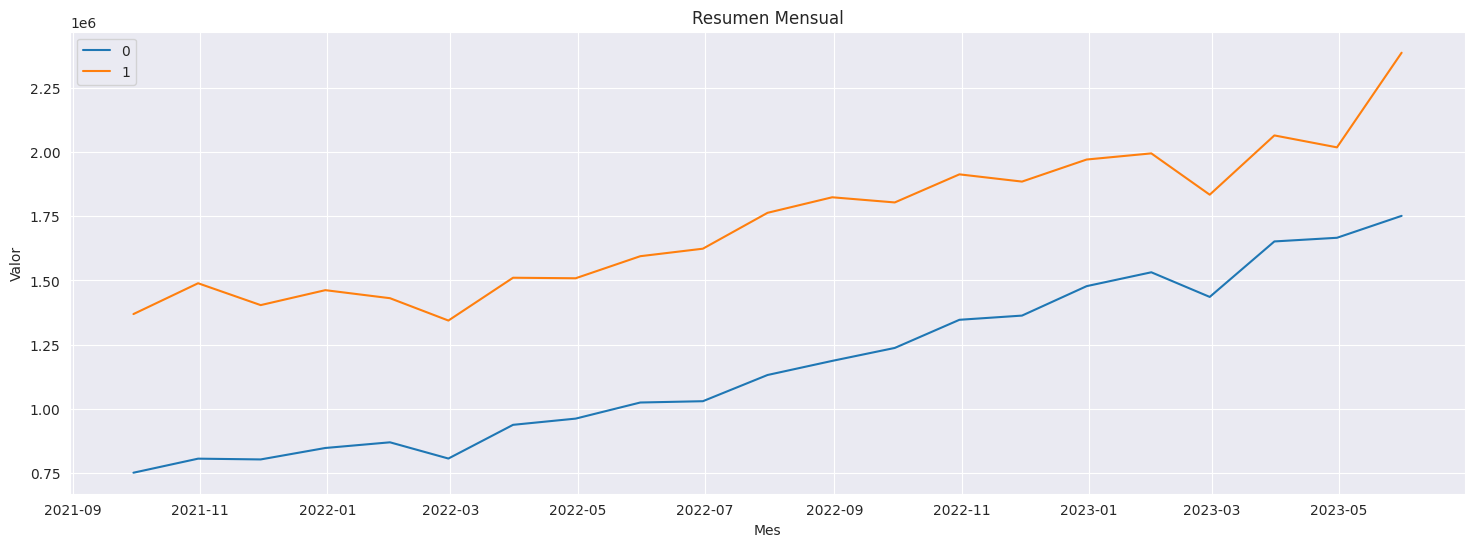

In [33]:
graficar_ts(client, date_time='datetime_client', target_column= 'installed_capacity', group_by='is_business')

El gráfico de serie temporal de 'installed_capacity' con la variable 'is_business' como variable categórica muestra diferencias en la tendencia temporal entre los clientes comerciales y no comerciales. Los clientes comerciales tienen una tendencia más pronunciada en comparación con los no comerciales, lo que sugiere que el tipo de cliente puede influir en la capacidad instalada.

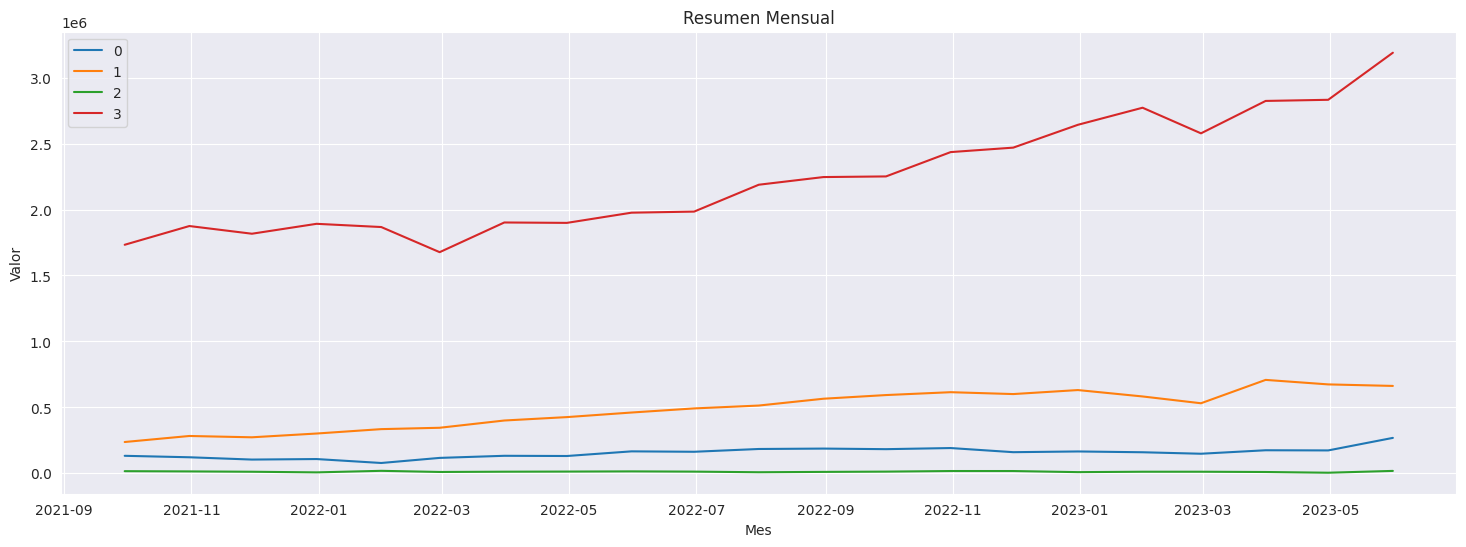

In [34]:
graficar_ts(client, date_time='datetime_client', target_column= 'installed_capacity', group_by='product_type')

El gráfico de serie temporal de 'installed_capacity' con la variable 'product_type' como variable categórica muestra diferencias en la tendencia temporal entre los diferentes tipos de producto. Algunos tipos de producto tienen una tendencia más pronunciada en comparación con otros, lo que sugiere que el tipo de producto puede influir en la capacidad instalada.

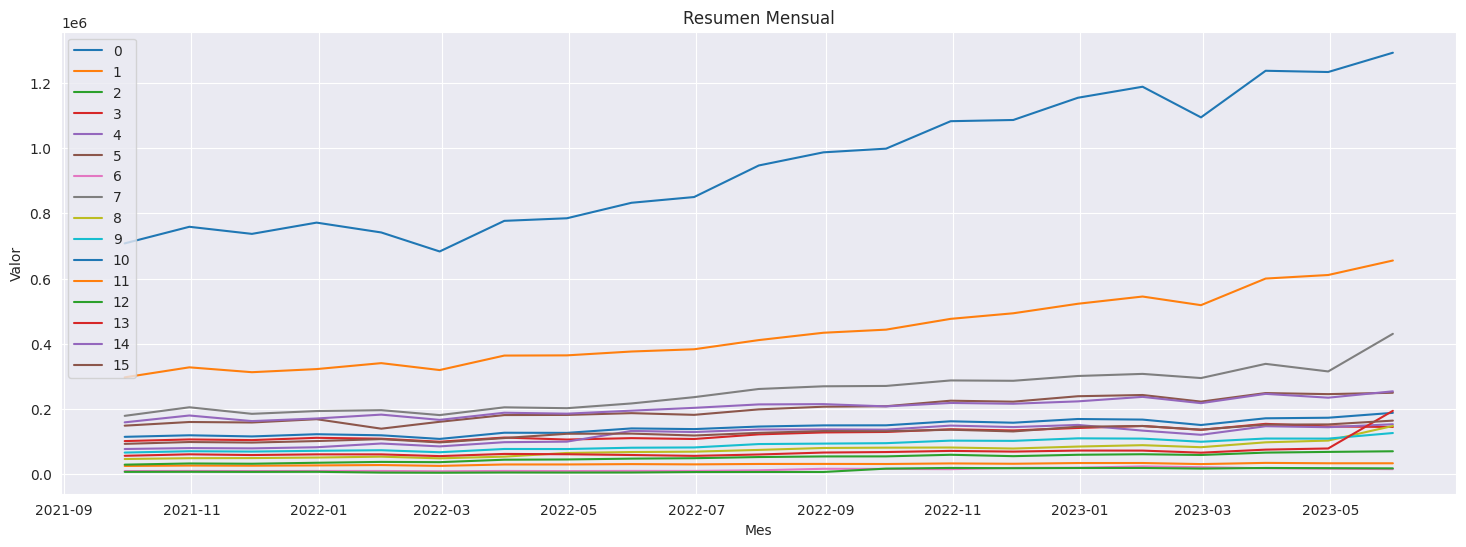

In [35]:
graficar_ts(client, date_time='datetime_client', target_column= 'installed_capacity', group_by='county')

El gráfico de serie temporal de 'installed_capacity' con la variable 'county' como variable categórica muestra diferencias en la tendencia temporal entre los diferentes condados. Algunos condados tienen una tendencia más pronunciada en comparación con otros, lo que sugiere que la ubicación geográfica puede influir en la capacidad instalada.

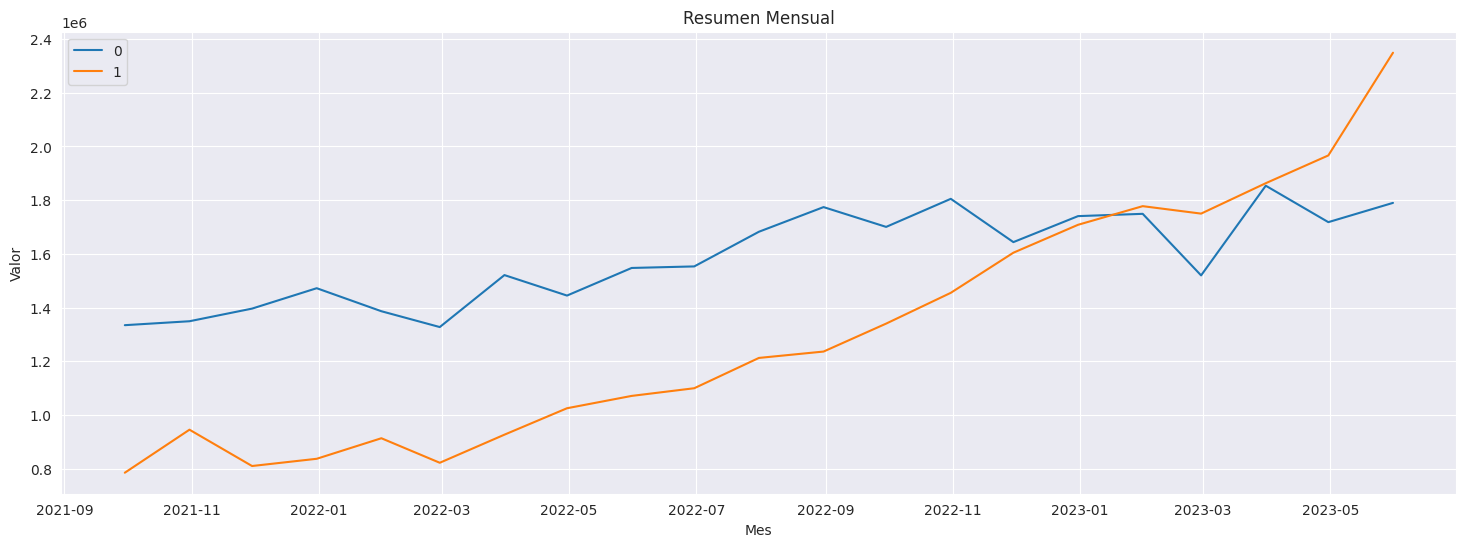

In [36]:
graficar_ts(client, date_time='datetime_client', target_column= 'installed_capacity', group_by='is_outlier')

El gráfico de serie temporal de 'installed_capacity' con la variable 'is_outlier' como variable categórica muestra diferencias en la tendencia temporal entre los valores atípicos y no atípicos. Los valores atípicos parecen tener una tendencia más pronunciada en comparación con los valores no atípicos, lo que sugiere que la presencia de valores atípicos puede influir en la tendencia temporal de la capacidad instalada.

## Precios de Electricidad

* origin_date
* forecast_date - Represents the start of the 1-hour period when the price is valid
* euros_per_mwh - The price of electricity on the day ahead markets in euros per megawatt hour.
* data_block_id

In [37]:
electricity_prices.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [38]:
electricity_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   forecast_date  15286 non-null  object 
 1   euros_per_mwh  15286 non-null  float64
 2   origin_date    15286 non-null  object 
 3   data_block_id  15286 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 477.8+ KB


<Figure size 1800x600 with 0 Axes>

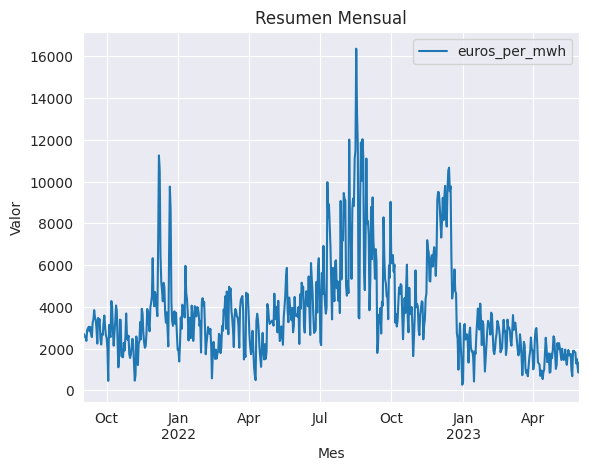

In [39]:
graficar_ts(electricity_prices, 'forecast_date', 'euros_per_mwh', freq='D')

El gráfico de serie temporal de 'euros_per_mwh' muestra una tendencia estacional en los precios de la electricidad. Los precios parecen aumentar y disminuir en ciertos períodos, lo que sugiere que la estacionalidad puede influir en los precios de la electricidad.

## Precios de Gas

* origin_date - The date when the day-ahead prices became available.
* forecast_date - The date when the forecast prices should be relevant.
* [lowest/highest]_price_per_mwh - The lowest/highest price of natural gas that on the day ahead market that trading day, in Euros per megawatt hour equivalent.
* data_block_id

In [40]:
gas_prices.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [41]:
gas_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   forecast_date          637 non-null    object 
 1   lowest_price_per_mwh   637 non-null    float64
 2   highest_price_per_mwh  637 non-null    float64
 3   origin_date            637 non-null    object 
 4   data_block_id          637 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 25.0+ KB


In [42]:
gas_prices['average_price_per_mwh'] = (gas_prices['lowest_price_per_mwh'] + gas_prices['highest_price_per_mwh']) / 2

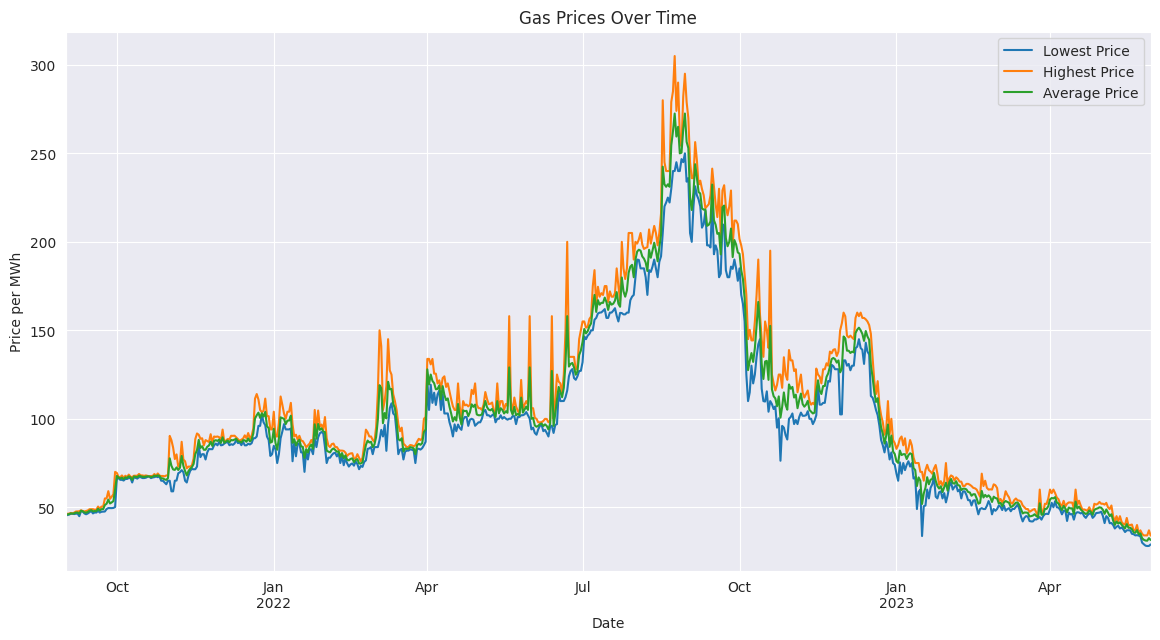

In [43]:
gas_prices['forecast_date'] = pd.to_datetime(gas_prices['forecast_date'])

# Configurar 'forecast_date' como el índice
gas_prices.set_index('forecast_date', inplace=True)

# Dibujar las series de tiempo
plt.figure(figsize=(14, 7))
gas_prices['lowest_price_per_mwh'].plot(label='Lowest Price')
gas_prices['highest_price_per_mwh'].plot(label='Highest Price')
gas_prices['average_price_per_mwh'].plot(label='Average Price')

# Configurar el título y las etiquetas
plt.title('Gas Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price per MWh')

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

El gráfico de serie temporal de los precios del gas muestra una tendencia estacional en los precios del gas. Los precios más bajos y más altos parecen aumentar y disminuir en ciertos períodos, lo que sugiere que la estacionalidad puede influir en los precios del gas.

## Clima Histórico

A continuación se filtran las fechas de 'historical_weather' para que coincidan con las fechas de 'train'.

In [44]:
historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])

In [45]:
historical_weather = historical_weather.copy().loc[historical_weather.datetime.isin(list(train.datetime.unique()))]

In [46]:
historical_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1710802 entries, 0 to 1710801
Data columns (total 18 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   datetime                datetime64[ns]
 1   temperature             float64       
 2   dewpoint                float64       
 3   rain                    float64       
 4   snowfall                float64       
 5   surface_pressure        float64       
 6   cloudcover_total        int64         
 7   cloudcover_low          int64         
 8   cloudcover_mid          int64         
 9   cloudcover_high         int64         
 10  windspeed_10m           float64       
 11  winddirection_10m       int64         
 12  shortwave_radiation     float64       
 13  direct_solar_radiation  float64       
 14  diffuse_radiation       float64       
 15  latitude                float64       
 16  longitude               float64       
 17  data_block_id           float64       
dtypes: date

In [47]:
historical_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


In [48]:
def plot_some_weather(data):
    
    try:
        data['datetime'] = pd.to_datetime(data['datetime'])
    except:
        pass
    
    try:
        data.set_index('datetime', inplace=True)
    except:
        pass
    
    # Crear un grid de 5x1 subplots
    fig, axes = plt.subplots(5, 1, figsize=(14, 35))
    
    # Dibujar las series de tiempo en gráficos separados
    data['temperature'].plot(ax=axes[0], label='Temperature')
    data['dewpoint'].plot(ax=axes[1], label='Dewpoint')
    data['rain'].plot(ax=axes[2], label='Rain')
    data['snowfall'].plot(ax=axes[3], label='Snowfall')
    data['surface_pressure'].plot(ax=axes[4], label='Surface Pressure')
    
    # Configurar los títulos y las etiquetas
    axes[0].set_title('Temperature Over Time')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Temperature')
    
    axes[1].set_title('Dewpoint Over Time')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Dewpoint')
    
    axes[2].set_title('Rain Over Time')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Rain')
    
    axes[3].set_title('Snowfall Over Time')
    axes[3].set_xlabel('Date')
    axes[3].set_ylabel('Snowfall')
    
    axes[4].set_title('Surface Pressure Over Time')
    axes[4].set_xlabel('Date')
    axes[4].set_ylabel('Surface Pressure')
    
    # Mostrar las leyendas
    axes[0].legend()
    axes[1].legend()
    axes[2].legend()
    axes[3].legend()
    axes[4].legend()
    
    # Ajustar el layout
    plt.tight_layout()
    
    # Mostrar los gráficos
    plt.show()

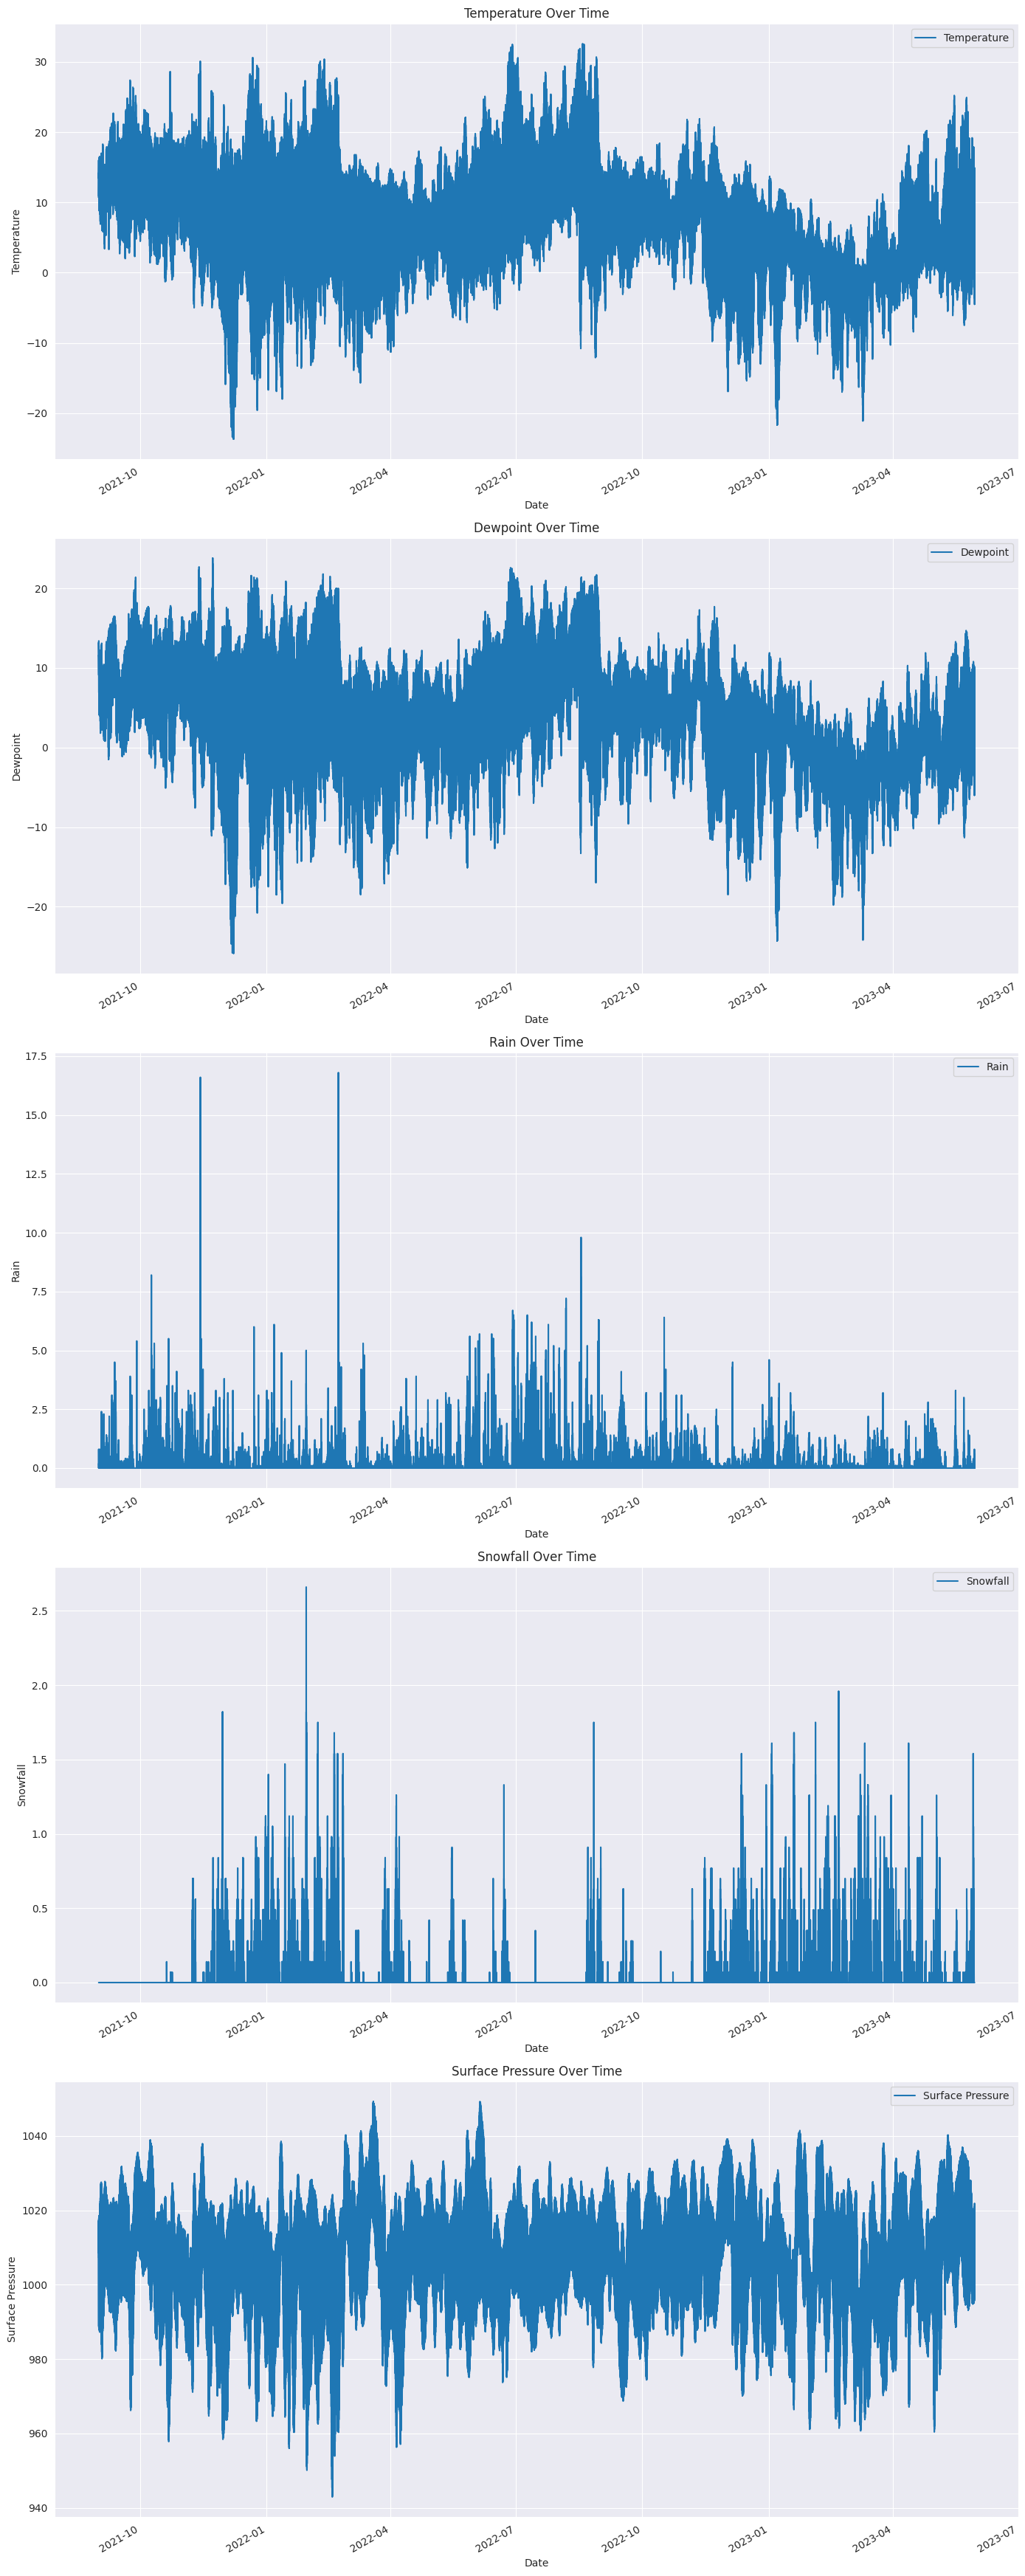

In [49]:
plot_some_weather(historical_weather)

Los gráficos de serie temporal de las variables climáticas muestran tendencias estacionales en la temperatura, el punto de rocío, la lluvia, la nieve y la presión de superficie. Estas tendencias estacionales pueden influir en la producción y el consumo de energía, ya que las condiciones climáticas pueden afectar la demanda de energía y la generación de energía renovable.

## wheater station to county mapping

In [50]:
wheater_station = pd.read_csv('../data/weather_station_to_county_mapping.csv')
wheater_station = wheater_station.loc[(wheater_station['latitude'] > 0) |
                                      (wheater_station['longitude'] > 0)]

In [51]:
wheater_station.head()

,county_name,longitude,latitude,county
0,NaN,21.7,57.6,NaN
1,NaN,21.7,57.9,NaN
2,NaN,21.7,58.2,NaN
3,NaN,21.7,58.5,NaN
4,NaN,21.7,58.8,NaN


## Mapa de Estaciones Meteorológicas

In [52]:
import geopandas as gpd
from shapely.geometry import Point

In [53]:
# Crear una columna 'geometry' con las coordenadas de las estaciones meteorológicas
wheater_station['geometry'] = [Point(x, y) for x, y in zip(wheater_station['longitude'], wheater_station['latitude'])]

In [54]:
# Crear un GeoDataFrame a partir del DataFrame
gdf = gpd.GeoDataFrame(wheater_station, geometry='geometry')

In [55]:
# Cargar el mapa de Estonia
estonia_ = gpd.read_file('../data/alusdokument.shp')

In [56]:
estonia_.crs = 'EPSG:3301'

In [57]:
# Establecer el CRS de gdf a WGS84
gdf.crs = 'EPSG:4326'

# Transformar gdf al CRS de estonia_
gdf = gdf.to_crs(estonia_.crs)

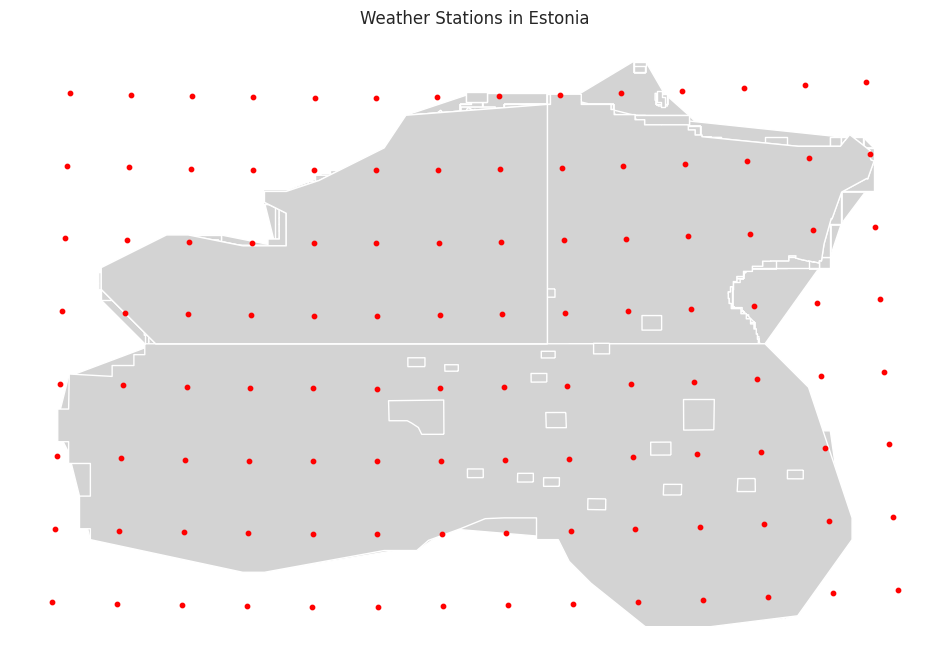

In [58]:
# Crear un gráfico de dispersión de las estaciones meteorológicas
fig, ax = plt.subplots(figsize=(12, 12))
estonia_.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, color='red', markersize=10)
plt.title('Weather Stations in Estonia')
plt.axis('off')
plt.show()